### Construct the Bayesian deep learning model 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Dropout,LSTM,Activation
from keras.optimizers import Adam
from keras.regularizers import l1,l2
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
import json
import seaborn as sns

Using TensorFlow backend.


In [4]:
all_para=pd.read_csv('all_all_sele_fea_26_spearman.csv')
all_para=all_para.values

In [9]:
### key_list is the one used to do feature sorting and selection
key_list=['dis','LATP','LONP','MSQT_1','BAL1','TAS','GS','TH','FLAP','GLS','LOC','N1_1','PTCH','ROLL','TRK','AIL_1','RUDD','ELEV_1',\
         'BLAC','CTAC','FPAC','CCPC','CWPC','WS','WD','ALTR']

In [10]:
#### sele_key_list is the one used to generate the RNN_x
sele_key_list=['CCPC','CTAC','PTCH','ELEV_1','BLAC','N1_1','GS','TAS','GLS','WS','ROLL','FPAC','WD','LONP','TH','LATP','dis','AIL_1','LOC','TRK','BAL1','RUDD','FLAP','ALTR']

In [11]:
RNN_x = np.load('RNN_x_sele.npy')
RNN_y = np.load('RNN_y.npy')
RNN_y_mean = np.mean(RNN_y)
RNN_y_std = np.std(RNN_y)
stand_RNN_y = (RNN_y-RNN_y_mean)/(RNN_y_std)
RNN_y_scale = np.load('RNN_y_scale.npy')
RNN_y_scale_reverse = np.exp(RNN_y_scale)-1+np.min(RNN_y)
#### the RNN_y_scale_reverse is not the true RNN_y,you need to add the diff to get the true RNN_y
### move altr to the first place
# new_RNN_x_index = np.insert(np.arange(RNN_x.shape[2]),0,23)[:RNN_x.shape[2]]
# RNN_x = RNN_x[:,:,new_RNN_x_index]


diff = np.mean(RNN_y)-np.mean(RNN_y_scale_reverse)

key_list=['dis','LATP','LONP','MSQT_1','BAL1','TAS','GS','TH','FLAP','GLS','LOC','N1_1','PTCH','ROLL','TRK','AIL_1','RUDD','ELEV_1',\
         'BLAC','CTAC','FPAC','CCPC','CWPC','WS','WD','ALTR']
### the difference between key_list and final_key_list is that key_list include latp and lonp
height_list=np.array([200,100,50,40,30,20,10,8,6,4,2])


def train_data(RNN_x,num_parameter):
    return (RNN_x[:,:,:num_parameter])



def get_RNN_model(in_shape, idrop=0.25, odrop=0.25, rdrop=0.25, weight_decay=1e-4, lr=1e-3,num_unit=100):

    model=Sequential()
    model.add(LSTM(num_unit,kernel_regularizer=l2(weight_decay),recurrent_regularizer=l2(weight_decay),bias_regularizer=l2(weight_decay),dropout=idrop,recurrent_dropout=rdrop,input_shape=(None,in_shape),\
                  kernel_initializer='random_uniform',return_sequences=True))

    model.add(Activation('relu'))
    
    model.add(LSTM(num_unit,dropout=idrop,recurrent_dropout=rdrop,return_sequences=False,kernel_regularizer=l2(weight_decay),recurrent_regularizer=l2(weight_decay),bias_regularizer=l2(weight_decay),kernel_initializer='random_uniform',))
    model.add(Activation('relu'))
    if odrop:
        model.add(Dropout(odrop))
    model.add(Dense(1,activation='linear',kernel_regularizer=l2(weight_decay),bias_regularizer=l2(weight_decay)))
    optimizer_=Adam(lr)
    #in the paper variational dropout, learning rate isn't considered
#     optimizer=Adam
    model.compile(loss='mse',metrics=['mse'],optimizer=optimizer_)
    return model

def get_RNN_model_2(in_shape, idrop=0.25, odrop=0.25, rdrop=0.25, weight_decay=1e-4, lr=1e-3,num_unit=100):

    model=Sequential()
    model.add(LSTM(num_unit,kernel_regularizer=l1(weight_decay),recurrent_regularizer=l1(weight_decay),bias_regularizer=l1(weight_decay),dropout=idrop,recurrent_dropout=rdrop,input_shape=(None,in_shape),\
                  kernel_initializer='random_uniform',return_sequences=True))

    model.add(Activation('relu'))
    
    model.add(LSTM(num_unit,dropout=idrop,recurrent_dropout=rdrop,return_sequences=False,kernel_regularizer=l1(weight_decay),recurrent_regularizer=l1(weight_decay),bias_regularizer=l1(weight_decay)))
    model.add(Activation('relu'))
    if odrop:
        model.add(Dropout(odrop))
    model.add(Dense(1,activation='linear',kernel_regularizer=l1(weight_decay),bias_regularizer=l1(weight_decay)))
    optimizer_=Adam(lr)
    #in the paper variational dropout, learning rate isn't considered
#     optimizer=Adam
    model.compile(loss='mse',metrics=['mse'],optimizer=optimizer_)
    return model
    
    

class KerasDPprediction(object):
    def __init__(self,model):
        self.f= K.function([model.layers[0].input,K.learning_phase()],[model.layers[-1].output])
        
    def predict(self,x,n_iter=1000):
        result=[]
        for _ in range(n_iter):
            result.append(np.squeeze(self.f([x,1])))
        result = np.array(result)
        
        return result

In [13]:
## here we're using the last column of the parameters to train the model
# final_RNN_x = RNN_x[:,:,final_para_index[:,-1]]
sele_key_list=['CCPC','CTAC','PTCH','ELEV_1','BLAC','N1_1','GS','TAS','GLS','WS','ROLL','FPAC','WD','LONP','TH','LATP','dis','AIL_1','LOC','TRK','BAL1','RUDD','FLAP','ALTR']

all_all_result = []
all_all_RMSE=[]
all_all_MAE = []

for j in range(1):
    print('j: '+str(j))
    sort_index = []
    sele_col = 2
    ### sele_col: 0-4
    for i in range(all_para.shape[0]):
        if all_para[i,sele_col] in sele_key_list:
            sort_index.append(sele_key_list.index(all_para[i,sele_col]))
#     sort_index = np.insert(sort_index,0,23)

    final_RNN_x = RNN_x[:,:,sort_index]
    all_result=[]
    all_RMSE=[]
    all_MAE = []
    for i in np.arange(4,28,4):
        print('i: '+str(i))
        ### i is the number of parameters taken to construct the training model
        partial_data = train_data(final_RNN_x,i)
        #### the model is trained based on RNN_y_scale_reverse
        RNN_x_train,RNN_x_test,RNN_y_train,RNN_y_test=train_test_split(partial_data[:,:,:], RNN_y_scale_reverse, test_size=0.2, random_state=40)
    #     RNN_x_train,RNN_x_test,RNN_y_train,RNN_y_test=train_test_split(partial_data[:,:,:],RNN_y, test_size=0.2, random_state=40)
        RNN_model = get_RNN_model(RNN_x_train.shape[2])
        RNN_model.fit(RNN_x_train,RNN_y_train,batch_size=30,verbose=False,epochs=200)
        kdp = KerasDPprediction(RNN_model)
        y_test_pred=kdp.predict(RNN_x_test,1000)
        all_result.append(y_test_pred)
        mean_y_test_pred = np.mean(y_test_pred,axis=0)
        RMSE =np.sqrt(np.mean((mean_y_test_pred-RNN_y_test)**2)) 
        MAE = np.mean(np.abs(mean_y_test_pred-RNN_y_test))

        all_RMSE.append(RMSE)
        all_MAE.append(MAE)
    all_all_result.append(all_result)
    all_all_RMSE.append(all_RMSE)
    all_all_MAE.append(all_MAE)

j: 0
i: 4
i: 8
i: 12
i: 16
i: 20
i: 24


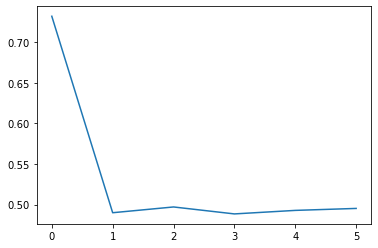

In [20]:
plt.plot(all_all_MAE[0])